# **Dataset 5: Portuguese School**

In this notebook we'll go through the entire process of exploratory data analysis, synthetic data generation (SDG) and evaluation for Dataset 5: Portuguese School.

The evaluation approach that is used was suggested by  Liu et al. [1]. The goal is to provide a comprehensive evaluation for synthetic tabular data in learning analytics that encompasses utility, resemblance and privacy metrics. The dataset used in this notebook is collected from two Portuguese schools.

Dataset source: https://archive.ics.uci.edu/dataset/320/student+performance

**References:**

> [1] Qinyi Liu, Mohammad Khalil, Ronas Shakya, and Jelena Jovanovic. 2024.
Scaling While Privacy Preserving: A Comprehensive Synthetic Tabular
Data Generation and Evaluation in Learning Analytics. In The 14th Learning
Analytics and Knowledge Conference (LAK ’24), March 18–22, 2024, Kyoto,
Japan. ACM, New York, NY, USA, 12 pages. https://doi.org/10.1145/3636555.
3636921

### **Import Packages**

In [1]:
import os
import sys
import multiprocessing
import subprocess
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath("../src"))

from generation.data_synthesizer import ds_generate_data
from generation.synthetic_data_vault import sdv_generate_data
from evaluation.utility import run_utility_eval
from evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from evaluation.privacy import dcr, nndr, mia

## **Exploratory Data Analysis**

In [2]:
data_path = "../data/original_data/5_portuguese_school/5_portuguese_school.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [4]:
original_data.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [5]:
original_data.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
G1            17
G2            17
G3            18
dtype: int64

In [6]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

school ['GP' 'MS']
sex ['F' 'M']
address ['U' 'R']
famsize ['GT3' 'LE3']
Pstatus ['A' 'T']
Mjob ['at_home' 'health' 'other' 'services' 'teacher']
Fjob ['teacher' 'other' 'services' 'health' 'at_home']
reason ['course' 'other' 'home' 'reputation']
guardian ['mother' 'father' 'other']
schoolsup ['yes' 'no']
famsup ['no' 'yes']
paid ['no' 'yes']
activities ['no' 'yes']
nursery ['yes' 'no']
higher ['yes' 'no']
internet ['no' 'yes']
romantic ['no' 'yes']


<Axes: xlabel='G3', ylabel='Count'>

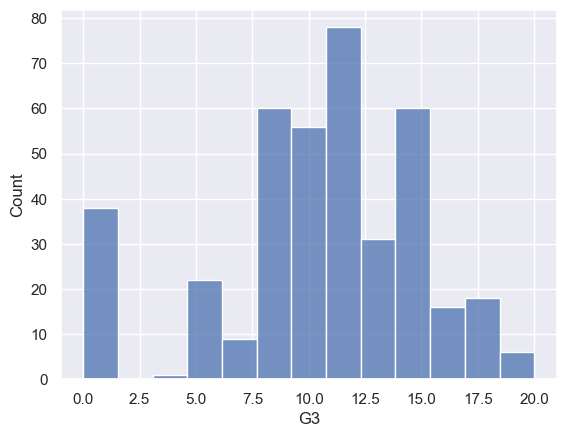

In [7]:
# Check class distribution
sns.histplot(original_data['G3'])

## **Synthetic Data Generation**

In [8]:
original_data_path = "../data/original_data/5_portuguese_school/"
train_file = os.path.join(original_data_path, "train_data.csv")
test_file = os.path.join(original_data_path, "test_data.csv")

# Prüfen, ob beide Dateien existieren
if os.path.isfile(train_file) and os.path.isfile(test_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    print("Train and test data loaded.")
else:
    train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    print("Train and test data saved.")

Train and test data loaded.


In [9]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

synth_path = "../data/synthetic_data/5_portuguese_school/"
dataset_name = "5_portuguese_school"
csv_files = [file for file in os.listdir(synth_path) if file.endswith(".csv")]

# Number of samples to generate
n = len(train_data)

if len(csv_files) == 0:
    # Use train_data.csv to fit SDG models and generate synthetic data
    data_path = original_data_path + "train_data.csv"
    arguments = [data_path, str(n), dataset_name]

    print("Sampling synthpop...")
    result = subprocess.run(['Rscript', '../src/generation/synthpop.R',   *arguments], capture_output=True, text=True)

    print("Sampling DataSynthesizer...")
    ds_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    sdv_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)
else:
    print("Synthetic data already exists.")

Synthetic data already exists.


Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [10]:
# Load the synthetic data as dataframe
synthpop = pd.read_csv(synth_path + "synthpop.csv")
ds = pd.read_csv(synth_path + "ds.csv")
tvae = pd.read_csv(synth_path + "tvae.csv")
gaussian_copula = pd.read_csv(synth_path + "gaussian_copula.csv")
copula_gan = pd.read_csv(synth_path + "copula_gan.csv")
ctgan = pd.read_csv(synth_path + "ctgan.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])
    original_data[col] = le.fit_transform(original_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le


In [11]:
train_data["G3"].nunique()

18

In [12]:
tvae["G3"].nunique()

15

## **Evaluation**

In [13]:
synth_datasets = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]

### **Resemblance**

The resemblance dimension includes mutliple distance metrics to measure the similarity of the synthetic and real data: **Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance**

- **Difference in pairwise correlation** is used to measure how well feature-interactions are preserved within synthetic data. First the pairwise correlation matrices for each real and synthetic data is computed. Pearson correlation coefficient is used for continuous features ( [-1,1] range) and the Theil uncer-
tainty coefficient ([0,1] range) for categorical features
    - lower (difference) values are better
- **JSD** is a method for measuring similarity between two probability distributions. It is based on Kullback-Leibler divergence, but has several benefits like being symmetric and having finite values. Values are bounded between 0 and 1, where values close to 0 indicate high similarity and values close to 1 indicate almost no similarity between the distributions.
    - lower values are better
- **WD** is used to compare the distributions of two continuous/mixed variables, where one variable is derived from the other → how well the synthetic data emulates the distribution of the
individual variables
    - lower values are better
**Difference in pairwise correlation:**

In [14]:
corr_diff_df = pd.read_csv("../data/results/tables/corr_diff.csv")
rows = []

if (corr_diff_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        result = pairwise_correlation_diff(train_data, synth_data)
        rows.append([5,model_names[i], result])

    rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
    corr_diff_df = pd.concat([corr_diff_df, rows])
    corr_diff_df.to_csv("../data/results/tables/corr_diff.csv", index=False)

corr_diff_df.tail(6)

Entry for 5 Portuguese School already exists.


,Dataset,Model,Pairwise Corr Diff
24,5,synthpop,0.068662
25,5,ds,0.135631
26,5,tvae,0.112384
27,5,gaussian_copula,0.088445
28,5,copula_gan,0.098838
29,5,ctgan,0.099111


**Jensen-Shannon Divergence**

In [15]:
jsd_df = pd.read_csv("../data/results/tables/jsd.csv")
rows = []

if (jsd_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        result = jsd(train_data, synth_data)
        rows.append([5,model_names[i], result])

    rows = pd.DataFrame(rows, columns=jsd_df.columns)
    jsd_df = pd.concat([jsd_df, rows])
    jsd_df.to_csv("../data/results/tables/jsd.csv", index=False)

jsd_df.tail(6)

Entry for 5 Portuguese School already exists.


,Dataset,Model,JSD Diff
24,5,synthpop,0.002518
25,5,ds,0.094244
26,5,tvae,0.173274
27,5,gaussian_copula,0.009733
28,5,copula_gan,0.024876
29,5,ctgan,0.026296


**Wasserstein Distance**

In [16]:
wd_df = pd.read_csv("../data/results/tables/wd.csv")
rows = []

if (wd_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        result = wd(train_data, synth_data)
        rows.append([5,model_names[i], result])

    rows = pd.DataFrame(rows, columns=wd_df.columns)
    wd_df = pd.concat([wd_df, rows])
    wd_df.to_csv("../data/results/tables/wd.csv", index=False)

wd_df.tail(6)

Entry for 5 Portuguese School already exists.


,Dataset,Model,WD Diff
24,5,synthpop,0.021479
25,5,ds,0.124192
26,5,tvae,0.274399
27,5,gaussian_copula,0.015656
28,5,copula_gan,0.040430
29,5,ctgan,0.035582


### **Privacy**

To assess the privacy aspect of the synthetic data the metrics **Distance to closest Record (DCR)**, **Nearest Neighbour Difference Ratio (NNDR)** and **Membership Inference Attack (MIA)** will be used. 

- In **DCR** the euclidean distance between
each record in original and synthetic dataset is computed. DCR is the minimum distance between a synthetic record and a original record. 
    - A value of zero indicates that the synthetic record is an identical copy of the original one -> leak of real information, higher values indicate more privacy

- **NNDR** is ratio between nearest and second nearest real neighbour to any corresponding synthetic record (NNDR(s) = d1/d2) and is within [0,1]
    - higher values indicate better privacy

- **MIA** is used to assess the disclosure risk by assuming that an attacker has access to all the records of the synthetic data and to a random subset of the original data. Using a real record the attacker then tries to find the closest record in the synthetic dataset. If there is any distance below some threshold, the attacker can assume that the corresponding real record was used to generate the synthetic data.
    - For strong privacy preservation both accuracy and precision should be below 0.5 for all thresholds

**Distance to closest record (DCR)**

In [18]:
dcr_df = pd.read_csv("../data/results/tables/dcr.csv")
rows = []
if (dcr_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        result = dcr(train_data, synth_data, model_names[i], dataset_name=dataset_name, save_hist=True)
        result_within_real = dcr(train_data, synth_data, model_names[i], dataset_name=dataset_name, within="Original", save_hist=True)
        result_within_synth = dcr(train_data, synth_data, model_names[i], dataset_name=dataset_name, within="Synthetic", save_hist=True)
        rows.append([5,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=dcr_df.columns)
    dcr_df = pd.concat([dcr_df, rows])
    dcr_df.to_csv("../data/results/tables/dcr.csv", index=False)

dcr_df.tail(6)

Entry for 5 Portuguese School already exists.


,Dataset,Model,DCR 5th Percentile,DCR 5th Percentile (within Real),DCR 5th Percentile (within Synthetic)
24,5,synthpop,3.708,3.708,3.742
25,5,ds,6.671,3.708,4.975
26,5,tvae,4.243,3.708,2.000
27,5,gaussian_copula,4.243,3.708,4.243
28,5,copula_gan,4.796,3.708,4.123
29,5,ctgan,5.454,3.708,4.873


**Nearest Neighbor distance ratio (NNDR)**

In [19]:
nndr_df = pd.read_csv("../data/results/tables/nndr.csv")
rows = []
if (nndr_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        result = nndr(train_data, synth_data)
        result_within_real = nndr(train_data, synth_data, within="Original")
        result_within_synth = nndr(train_data, synth_data, within="Synthetic")
        rows.append([5,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=nndr_df.columns)
    nndr_df = pd.concat([nndr_df, rows])
    nndr_df.to_csv("../data/results/tables/nndr.csv", index=False)

nndr_df.tail(6)

Entry for 5 Portuguese School already exists.


,Dataset,Model,NNDR 5th percentile,NNDR 5th percentile (within Real),NNDR 5th percentile (within Synthetic)
24,5,synthpop,0.750,0.771,0.791
25,5,ds,0.403,0.771,0.663
26,5,tvae,0.858,0.771,0.000
27,5,gaussian_copula,0.799,0.771,0.794
28,5,copula_gan,0.837,0.771,0.832
29,5,ctgan,0.500,0.771,0.775


**Membership Inference Attack (MIA)**

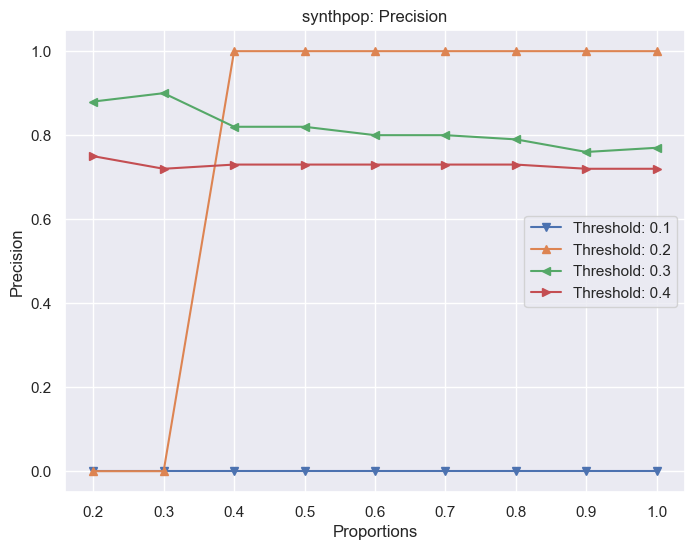

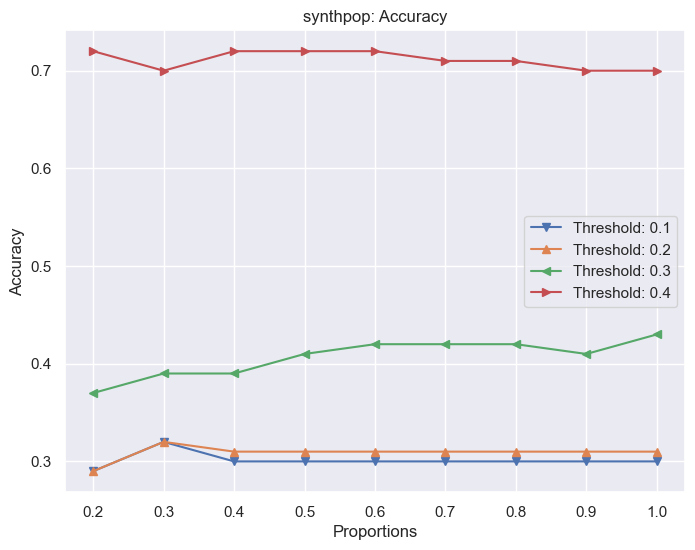

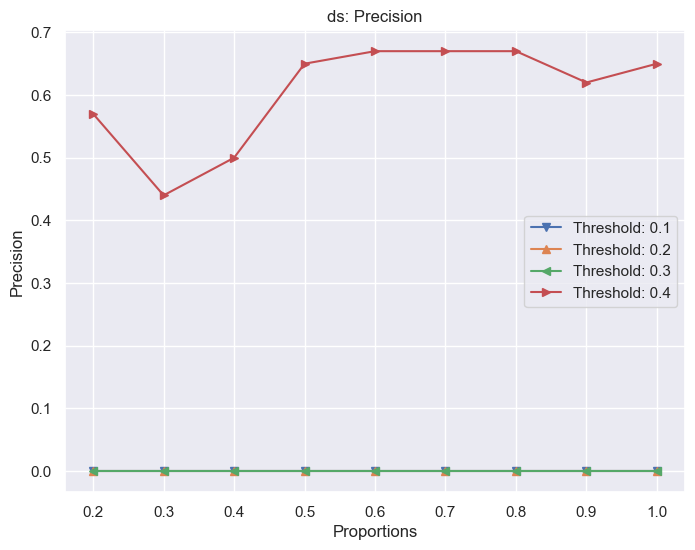

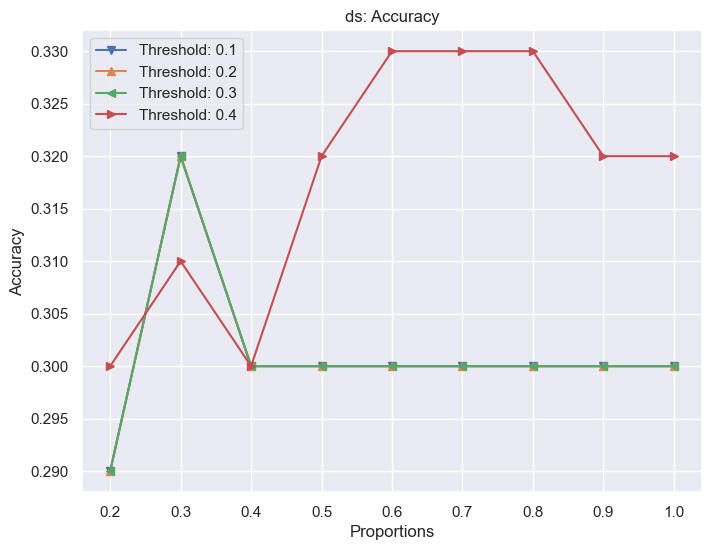

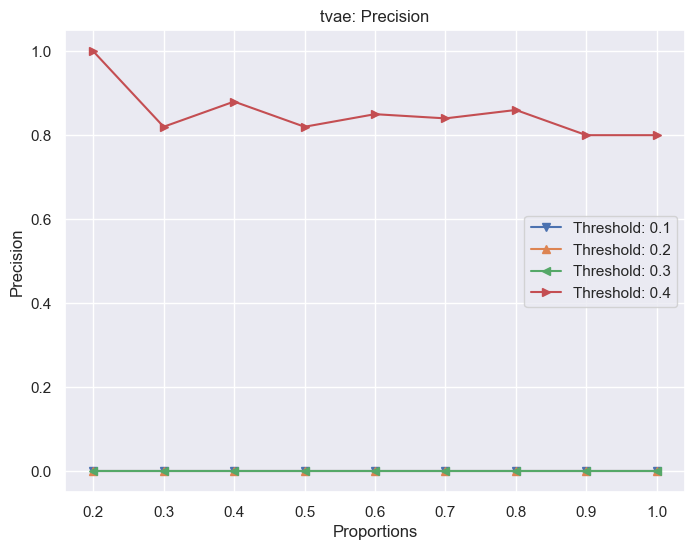

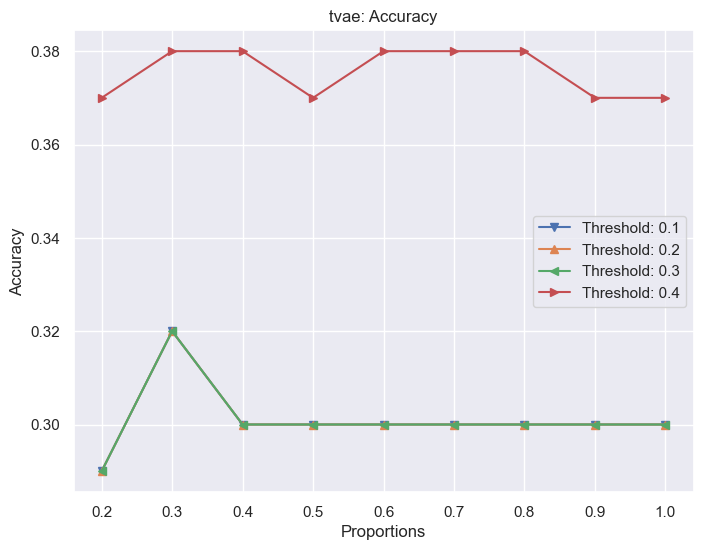

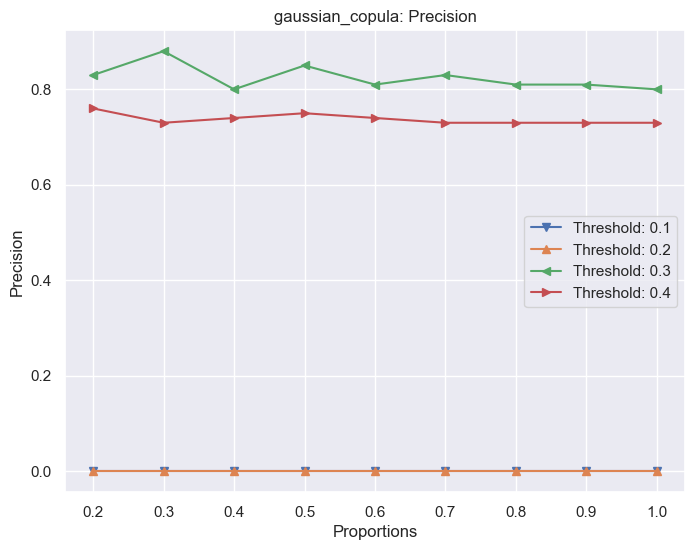

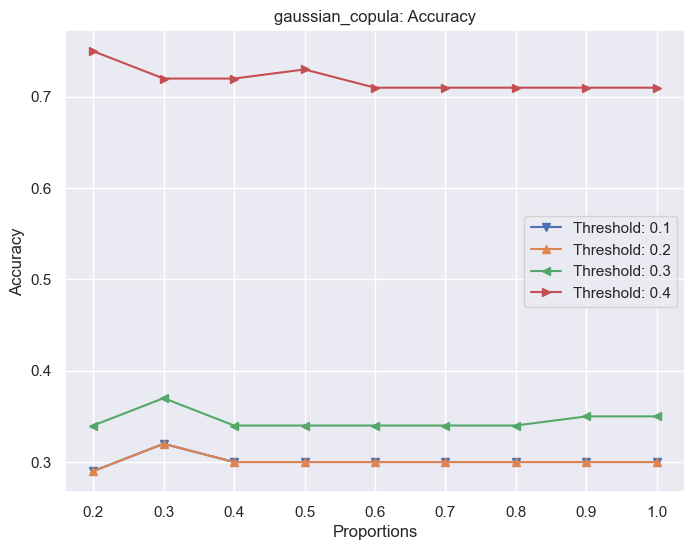

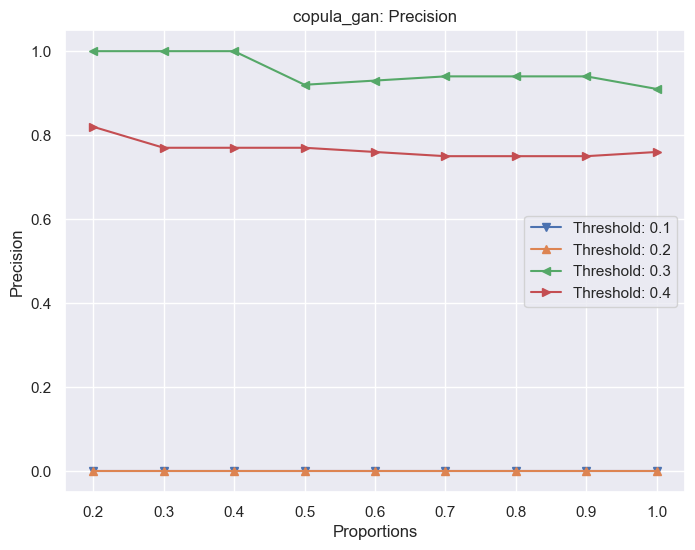

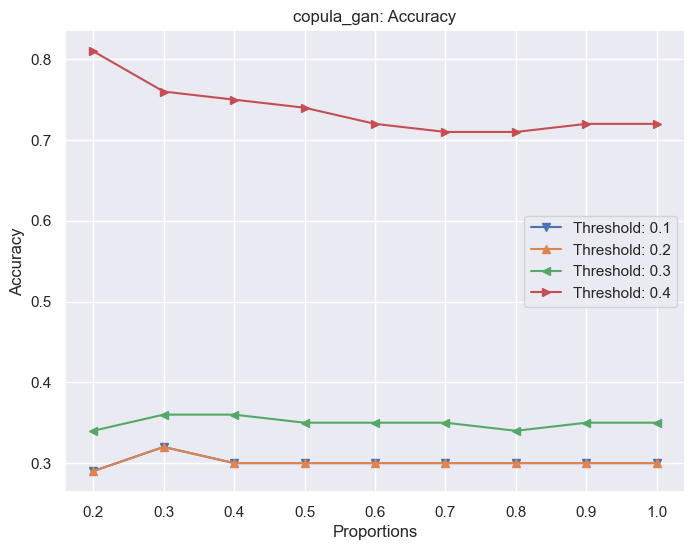

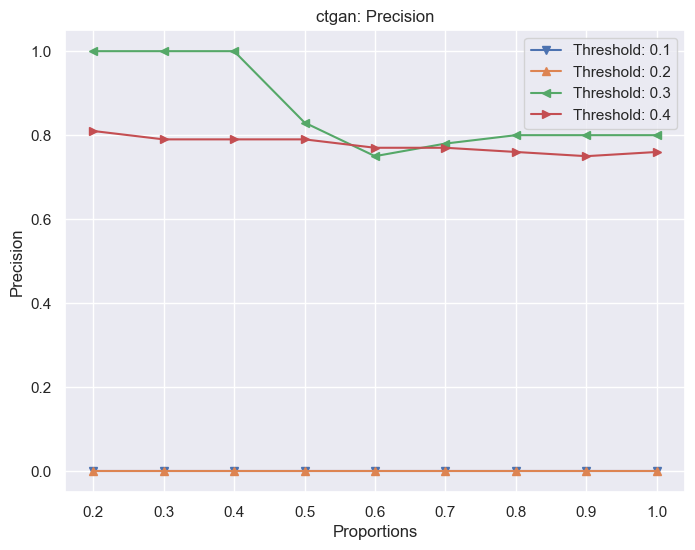

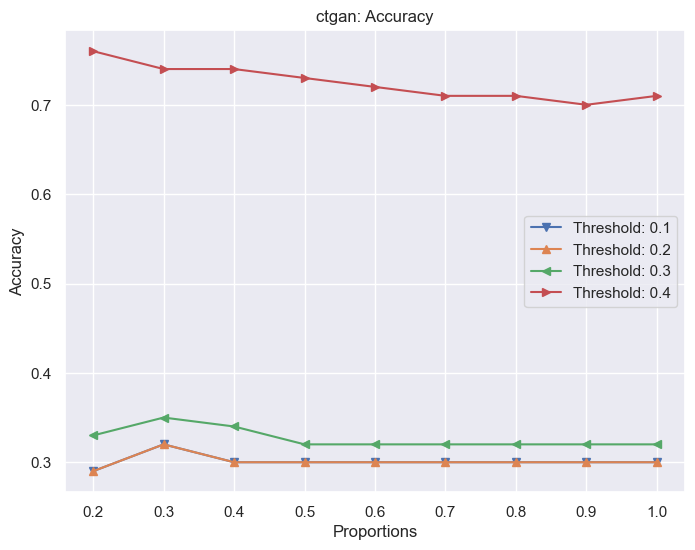

In [20]:
import glob

mia_results = {}
mia_path = "../data/results/plots/mia/5_portuguese_school/"
mia_files = glob.glob(os.path.join(mia_path, "*.png"))
if (mia_files):
    print("MIA results already exist.")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mia_results[model_names[i]] = mia(original_data, train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_plts=True)


In [21]:
proportions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

rows = []
for model, metrics in mia_results.items():
    for metric, thresholds in metrics.items():
        for threshold, values in thresholds.items():
            for proportion, value in zip(proportions, values):
                rows.append([5,model, metric, threshold, proportion, value])
                
mia_df = pd.read_csv("../data/results/tables/mia.csv")
rows = pd.DataFrame(rows, columns=mia_df.columns)
mia_df = pd.concat([mia_df, rows])
mia_df.to_csv("../data/results/tables/mia.csv", index=False)
mia_df.head()

,Dataset,Model,Metric,Threshold,Proportion,Value
0,1,synthpop,precision,0.1,0.2,0.0
1,1,synthpop,precision,0.1,0.3,0.0
2,1,synthpop,precision,0.1,0.4,0.0
3,1,synthpop,precision,0.1,0.5,0.0
4,1,synthpop,precision,0.1,0.6,0.0


### **Utility**

In order to evaluate the utility of the synthetic datasets, the following steps will executed three times, each time with a different ML model.

1. Two models are trained: one using the original train data and the other one using synthetic data.
2. The two different models will predict the target column using the test split.
3. The difference in performance between the two models will be reported via accuracy diff, f1-score diff, and auc-roc diff

In [44]:
# Set target column
target_col = "G3"

quantiles = train_data[target_col].quantile([0, 0.5, 0.8, 1]).values

train_data[target_col] = pd.cut(train_data[target_col], bins=quantiles, labels=[0, 1, 2], include_lowest=True)
test_data[target_col] = pd.cut(test_data[target_col], bins=quantiles, labels=[0, 1, 2], include_lowest=True)
train_data.drop(["G1", "G2"], axis=1, inplace=True)
test_data.drop(["G1", "G2"], axis=1, inplace=True)

for synth_dataset in synth_datasets:
    synth_dataset[target_col] = pd.cut(synth_dataset[target_col], bins=quantiles, labels=[0, 1, 2], include_lowest=True)
    synth_dataset.drop(["G1", "G2"], axis=1, inplace=True)

In [45]:
train_data.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      31
G3             3
dtype: int64

In [46]:
tvae.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,0,1,16,0,0,0,4,4,1,0,...,0,0,4,3,2,1,1,5,0,1
1,0,1,16,0,0,0,2,2,1,0,...,0,0,4,4,5,1,1,5,3,0
2,0,0,16,0,0,0,2,2,1,0,...,0,0,4,3,2,1,1,5,1,0
3,0,1,17,0,0,0,1,1,1,0,...,0,0,4,4,5,1,5,5,2,0
4,0,0,16,0,0,0,4,2,1,0,...,0,0,4,3,3,1,1,5,2,0


Run random forest classifier for utility evaluation

In [47]:
rf_results = {}
rows = []
rf_df = pd.read_csv("../data/results/tables/rf.csv")

if (rf_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        rf_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_data, target_col, "random_forest")

        acc_diff = rf_results[model_names[i]]["acc_diff"]
        f1_diff = rf_results[model_names[i]]["f1_diff"]
        roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]

        rows.append([5, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=rf_df.columns)
    rf_df = pd.concat([rf_df, rows], ignore_index=True)
    rf_df.to_csv("../data/results/tables/rf.csv", index=False)

rf_df.tail(6)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
18,5,synthpop,0.04,0.08,0.20
19,5,ds,0.03,0.08,0.14
20,5,tvae,0.04,0.03,0.16
21,5,gaussian_copula,0.12,0.07,0.17
22,5,copula_gan,0.00,0.08,0.26
23,5,ctgan,0.30,0.27,0.24


Run logistic regression for utility evaluation

In [48]:
lr_results = {}
lr_df = pd.read_csv("../data/results/tables/lr.csv")
rows = []

if (lr_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        lr_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_data, target_col, "logistic_regression")

        acc_diff = lr_results[model_names[i]]["acc_diff"]
        f1_diff = lr_results[model_names[i]]["f1_diff"]
        roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

        rows.append([5, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=lr_df.columns)
    lr_df = pd.concat([lr_df, rows])
    lr_df.to_csv("../data/results/tables/lr.csv", index=False)

lr_df.tail(6)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
0,5,synthpop,0.14,0.14,0.16
1,5,ds,0.31,0.26,0.13
2,5,tvae,0.25,0.24,0.12
3,5,gaussian_copula,0.27,0.25,0.15
4,5,copula_gan,0.08,0.20,0.24
5,5,ctgan,0.33,0.33,0.20


Run multilayer perceptron (MLP)

In [50]:
mlp_results = {}
mlp_df = pd.read_csv("../data/results/tables/mlp.csv")
rows = []

if (mlp_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_data, target_col, "multilayer_perceptron")

        acc_diff = mlp_results[model_names[i]]["acc_diff"]
        f1_diff = mlp_results[model_names[i]]["f1_diff"]
        roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

        rows.append([5, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=mlp_df.columns)
    mlp_df = pd.concat([mlp_df, rows])
    mlp_df.to_csv("../data/results/tables/mlp.csv", index=False)

mlp_df.tail(6)

Entry for 5 Portuguese School already exists.


,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
24,4,synthpop,0.07,0.06,0.01
25,4,ds,-0.08,-0.07,0.00
26,4,tvae,-0.08,-0.08,0.00
27,4,gaussian_copula,0.07,0.06,0.01
28,4,copula_gan,0.00,0.00,0.01
29,4,ctgan,0.07,0.06,0.01
